In [317]:
import math
import random

import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F

%matplotlib inline

In [3]:
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [6]:
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s, i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [149]:
block_size = 3 # how many characters do we take to predict the next one?

X, Y = [], []
context = [0] * block_size
for w in words:
    for ch in w+'.':
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)
        
        # print(''.join(itos[i] for i in context), f'---> {itos[ix]}')
        context = context[1:]+[ix]

X = torch.tensor(X)
Y = torch.tensor(Y)

In [150]:
C = torch.randn(27, 2)
C

tensor([[ 1.3908, -1.4296],
        [-0.0628, -1.8346],
        [-0.1505,  2.4267],
        [ 1.2535,  1.2580],
        [ 0.4162, -0.7127],
        [ 2.7012,  0.8105],
        [-0.0093,  1.1223],
        [-0.6683,  0.0294],
        [ 0.3303,  0.7599],
        [-0.5671, -0.4787],
        [ 0.8031, -0.3156],
        [-0.5095, -1.9646],
        [ 0.2903, -1.0216],
        [-0.1626,  2.2389],
        [ 0.4323, -1.0329],
        [ 0.7583, -0.5297],
        [ 0.6068,  0.0899],
        [ 1.4002,  0.1665],
        [-0.7191, -0.0824],
        [ 0.1543, -1.4397],
        [ 1.9108, -0.9360],
        [ 0.0660, -0.9151],
        [-1.5334,  0.2208],
        [-1.6557,  2.2199],
        [-0.3385,  2.4754],
        [-1.0093, -0.4861],
        [-1.2414, -2.6656]])

In [151]:
C[X].shape

torch.Size([228146, 3, 2])

In [152]:
X[23][1]

tensor(12)

In [153]:
C[X][23][1]

tensor([ 0.2903, -1.0216])

In [154]:
C[12]

tensor([ 0.2903, -1.0216])

In [155]:
emb = C[X]
emb.shape

torch.Size([228146, 3, 2])

In [156]:
W = torch.randn(6, 100)
b = torch.randn(100)

In [157]:
emb @ W + b

RuntimeError: mat1 and mat2 shapes cannot be multiplied (684438x2 and 6x100)

In [158]:
torch.cat([emb[:, 0, :], emb[:, 1, :], emb[:, 2, :]], 1).shape

torch.Size([228146, 6])

In [159]:
torch.cat(emb.unbind(1), 1).shape

torch.Size([228146, 6])

In [160]:
nums = torch.arange(18).view(2, 3, 3)
nums

tensor([[[ 0,  1,  2],
         [ 3,  4,  5],
         [ 6,  7,  8]],

        [[ 9, 10, 11],
         [12, 13, 14],
         [15, 16, 17]]])

In [161]:
nums.view(-1, 2, 3)

tensor([[[ 0,  1,  2],
         [ 3,  4,  5]],

        [[ 6,  7,  8],
         [ 9, 10, 11]],

        [[12, 13, 14],
         [15, 16, 17]]])

In [162]:
nums.storage() # torch stores flat tensors http://blog.ezyang.com/2019/05/pytorch-internals/

 0
 1
 2
 3
 4
 5
 6
 7
 8
 9
 10
 11
 12
 13
 14
 15
 16
 17
[torch.storage.TypedStorage(dtype=torch.int64, device=cpu) of size 18]

In [165]:
h = torch.tanh(emb.view(32, -1) @ W + b)

RuntimeError: shape '[32, -1]' is invalid for input of size 1368876

In [166]:
print(W.shape, b.shape)

torch.Size([6, 100]) torch.Size([100])


In [167]:
# 6, 100
#    100

# careful with torch broadcasting

In [168]:
W2 = torch.randn(100, 27)
b2 = 27

logits = h @ W2 +b2

In [169]:
logits.shape

torch.Size([32, 27])

In [170]:
counts = logits.exp()
probs = counts/counts.sum(1, keepdims=True)

In [171]:
probs.shape

torch.Size([32, 27])

In [172]:
loss = -probs[torch.arange(probs.shape[0]), Y].log().mean()
loss

IndexError: shape mismatch: indexing tensors could not be broadcast together with shapes [32], [228146]

In [173]:
# =-- cleaner version

In [322]:
def build_dataset(words):
    block_size = 3
    X, Y = [], []
    
    for w in words:
        context = [0] * block_size
        for ch in w+'.':
            ix = stoi[ch]
            
            X.append(context)
            Y.append(ix)
            context = context[1:]+[ix]
            
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words)); n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182441, 3]) torch.Size([182441])
torch.Size([22902, 3]) torch.Size([22902])
torch.Size([22803, 3]) torch.Size([22803])


In [350]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn(27, 2, generator=g)
W1 = torch.randn(6, 100, generator=g)
b1 = torch.randn(100, generator=g)
W2 = torch.randn(100, 27, generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [351]:
for p in parameters:
    p.requires_grad = True

In [314]:
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre # what 10^-3 and 10^0?

In [356]:
batch_size = 32

lri = []
lossi = []
stepi = []
for i in range(30000):
    
    ix = torch.randint(0, Xtr.shape[0], (batch_size, ))
    emb = C[Xtr[ix]]
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Ytr[ix])
    
    # print(loss.item()) 
    
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # lr = lrs[i]    
    lr = 0.1
    for p in parameters:
        p.data += -lr*p.grad
        
    # lri.append(lre[i])
    stepi.append(i)
    lossi.append(loss.item())

# print(loss.item())

In [357]:
print(loss.item())

2.1691946983337402


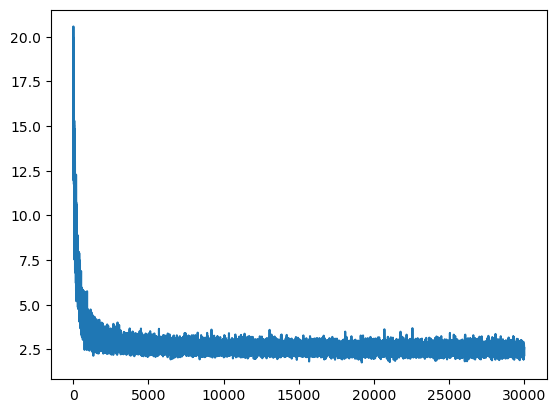

In [342]:
plt.plot(stepi, lossi)

In [359]:
emb = C[Xdev]
h = torch.tanh(emb.view(-1, 6) @ W1 +b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ydev)
loss.item()

2.4601941108703613

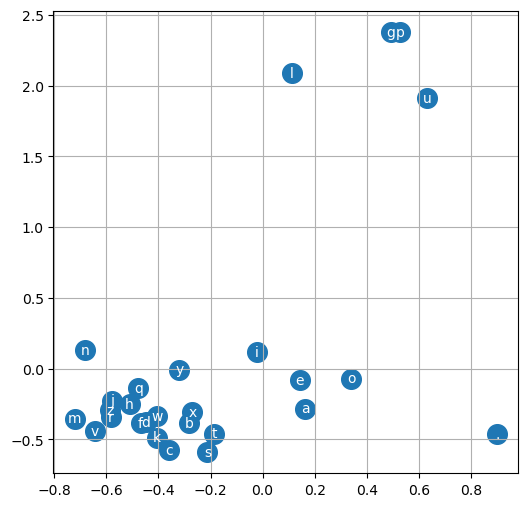

In [361]:
plt.figure(figsize=(6, 6))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i, 0].item(), C[i, 1].item(), itos[i], ha='center', va='center', color='white')
plt.grid('minor')

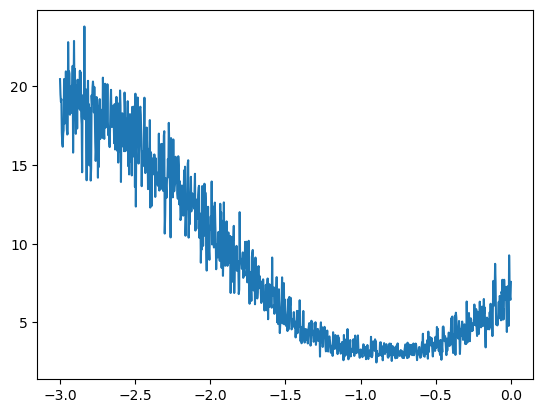

In [316]:
plt.plot(lri, lossi) # plot the graph to get the best learning rate. In this case 10^-1 = 0.01
# Now we are ready to train the model with this learning rate